# Final Project - Deep RL Learning in MultiRoom Environment

---

Name and ID:  
Student 1: 204266191
<br>
Student 2: 318947470
<br><br>


# Pre-Requisit


## Imports


In [1]:
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pyvirtualdisplay
import IPython
import base64
import gymnasium
import minigrid
from minigrid.wrappers import RGBImgObsWrapper, RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper, RGBImgPartialObsWrapper
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
print("Global dependencies loaded successfully")

Global dependencies loaded successfully


In [2]:
# our project imports
from minigrid.envs import MultiRoomEnv
import gymnasium as gym
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from cv2 import cvtColor
from pathlib import Path
from abc import ABC, abstractmethod
from typing import Tuple, List, Deque , Optional, Dict, Union
import importlib
from contextlib import contextmanager
import time

print("Local dependencies loaded successfully")

Local dependencies loaded successfully


In [3]:
from display_functions import show_full_frame_rgb, show_partial_greyscale, show_state_full_and_partial, plot_training_process
from env_functions import create_multiroom_env, get_action_meaning

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.amp import autocast, GradScaler

cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
    torch.backends.cudnn.benchmark = True  # Use optimized conv operations
    torch.backends.cudnn.enabled = True    # Ensure CuDNN is used
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # Default tensors on GPU


CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 4050 Laptop GPU
CUDA Device Count: 1


In [5]:
# Constants for the environemnt configuration do no change the values
highlight = False
render_mode = "rgb_array"
WORK_DIR = Path("C:/Users/ASUS/OneDrive/MSc MLDS/Reinforcement Learning/Projects/final-project")
ACTIONS_SPACES = [0, 1, 2, 5]
ACTIONS_SPACES_MAPPED = {0: 0, 1: 1, 2: 2, 5: 3}  
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Display Functions

The cell below contains the video display configuration. No need to make changes here.


In [6]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900), backend=None).start()

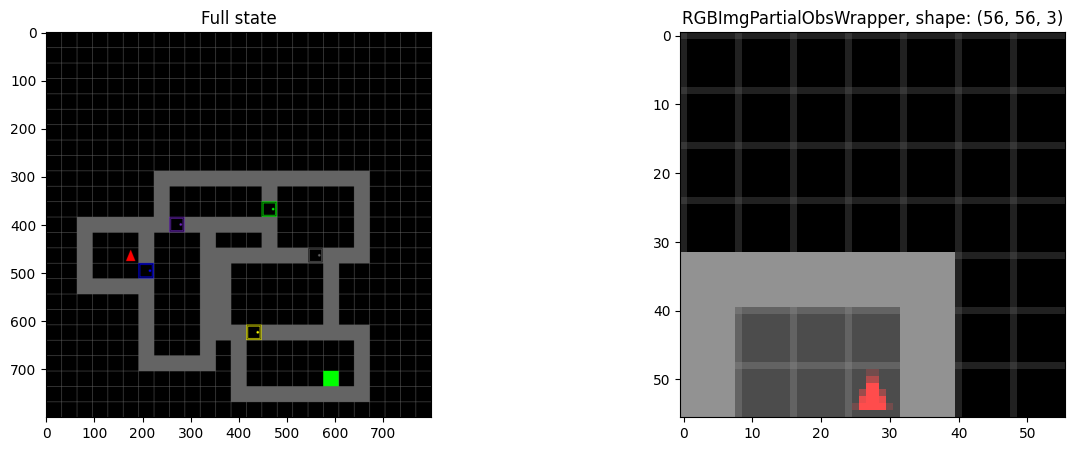

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(obs)
axs[1].title.set_text(f'RGBImgPartialObsWrapper, shape: {obs.shape}')
axs[0].imshow(env.render())
axs[0].title.set_text(f'Full state')
plt.show()

## Initializing the smaller environments


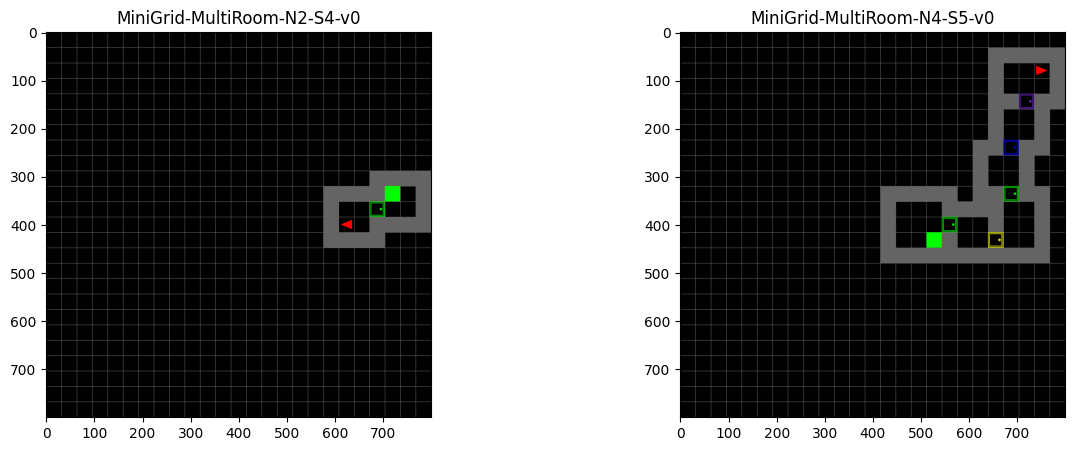

In [8]:
env = gymnasium.make("MiniGrid-MultiRoom-N2-S4-v0", render_mode=render_mode, highlight=highlight)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[0].imshow(env.render())
axs[0].title.set_text(f'MiniGrid-MultiRoom-N2-S4-v0')



env = gymnasium.make("MiniGrid-MultiRoom-N4-S5-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(env.render())
axs[1].title.set_text(f'MiniGrid-MultiRoom-N4-S5-v0')
plt.show()

### Partial Observation Example


In [9]:
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
# video_filename = '/content/vid_partial.mp4'
video_filename = "C:/Users/ASUS/OneDrive/MSc MLDS/Reinforcement Learning/Projects/final-project/videos/fdfdfdfdfdf.mp4"
truncated = False
# Evaluation
with imageio.get_writer(video_filename, fps=10) as video:
  obs, _ = env.reset()
  done = False
  total_reward = 0
  step = 0
  while not truncated:
      action = env.action_space.sample()
      obs, reward, done, truncated  , _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(obs)
      step += 1
      if truncated:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
# embed_mp4(video_filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (56, 56) to (64, 64) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


done reward= 0 num_of_steps= 120


# Our Code


## Auxiliary Functions


### Environment Functions

For better controll over randomization and the learning process, we will implement the create_multiroom_env function that allows us to create environments with any number of rooms of any size. It will help us to do the learning gradually. the get_action_meaning function will help use to make out put more readable.


### Display Functions

For advanced debugging purpose we implemented functions that allows us to visualize sequence of frames, compitalbe with MultiRoom API. In additin we implement render_agent_video for visualizing a give agent in a give environment.


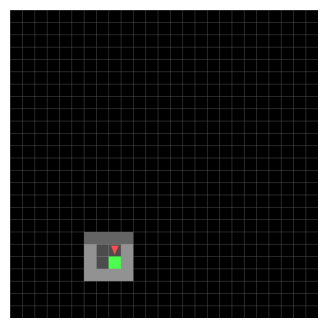

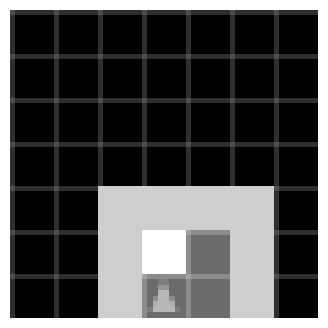

In [10]:
from display_functions import show_full_frame_rgb, show_partial_greyscale, render_agent_video, show_state_full_and_partial
env, obs = create_multiroom_env(1, 4)
img_rgb = show_full_frame_rgb(env, obs)
img_grey = show_partial_greyscale(env, obs)

--------------------------------------------------
Step 0
Action taken: 0 (Move Left)


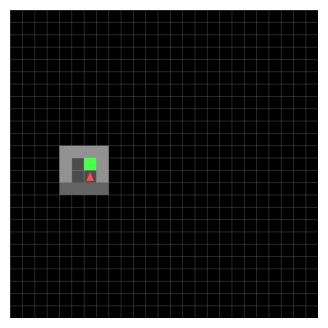

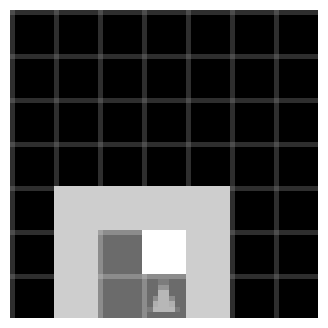

--------------------------------------------------
Step 1
Action taken: 0 (Move Left)


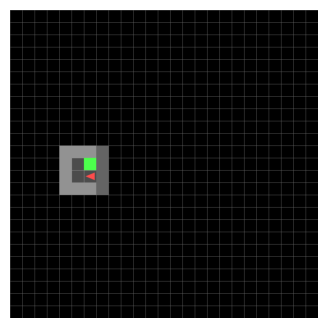

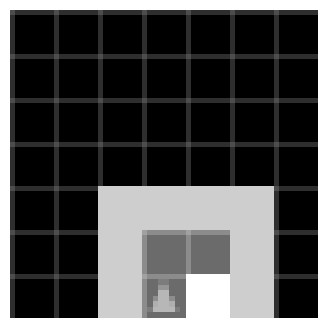

--------------------------------------------------
Step 2
Action taken: 1 (Move Right)


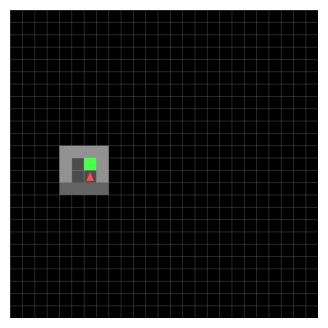

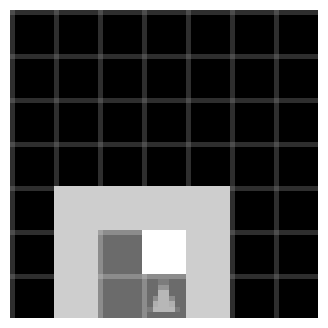

In [11]:
def show_N_steps(env, N, policy=None):
    """
    Runs N steps in the environment, rendering each step.

    Parameters:
        env: The environment instance.
        N (int): Number of steps to execute.
        policy (function): Function that takes obs and returns an action. Defaults to random.
    """
    if policy is None:
        policy = lambda obs: random.choice(ACTIONS_SPACES)  # Default to random actions

    obs, _ = env.reset()  # Ensure the environment starts correctly

    for i in range(N):
        print("--------------------------------------------------")
        print(f"Step {i}")

        action = policy(obs)  # Get action from policy
        print(f"Action taken: {action} ({get_action_meaning(action)})")
        obs, reward, done, truncated, info = env.step(action)

        show_full_frame_rgb(env, obs)
        show_partial_greyscale(env, obs)



        if done or truncated:  # Reset if the episode ends
            print("Environment reset!")
            obs, _ = env.reset()
env
# verification
show_N_steps(env, 3)


### Preprocess Class

Environments like MiniGrid MultiRoom require the agent to understand spatial dependencies and remember past observations to make optimal decisions. However, standard observations only provide a single frame, making it difficult for the agent to infer motion, detect doors opening, or track past locations. In order to deal with this, especially to encourage the agent to learn the process of open door and moving to the next room, we will implement FrameStackPreprocess. In addition, this class will convert the observation to greyscale becasue the RGB channels doesn't contribute to the learning process and do downsampling to better efficency and generalization (we don't need the fine details of the environment).


In [12]:
import numpy as np
import cv2
from collections import deque
from typing import Tuple

class FrameStackPreprocess:
    """
    A wrapper for preprocessing and stacking consecutive frames into different channels.
    - Converts RGB frames to grayscale.
    - Normalizes pixel values.
    - Optionally downsamples to a target size.
    - Stacks the last N frames to capture temporal information.

    Parameters:
        num_frames (int): Number of frames to stack.
        img_size (Tuple[int, int]): Original (Height, Width) of frames before processing.
        downsample_size (Tuple[int, int]): Target (Height, Width) after downsampling.
    """

    def __init__(self, num_frames: int = 3, img_size: Tuple[int, int] = (56, 56), 
                 downsample_size: Tuple[int, int] = (14, 14)) -> None:
        self.num_frames: int = num_frames
        self.frames: deque[np.ndarray] = deque(maxlen=num_frames)  # Store last N frames
        self.img_size: Tuple[int, int] = img_size  # Ensure all frames have the same shape
        self.downsample_size: Tuple[int, int] = downsample_size  # Target downsampling resolution

    def _convert_to_grayscale(self, frame: np.ndarray) -> np.ndarray:
        """
        Converts an RGB frame to grayscale.

        Args:
            frame (np.ndarray): Input RGB frame with shape (H, W, 3), dtype=np.uint8.

        Returns:
            np.ndarray: Grayscale frame with shape (H, W), dtype=np.uint8.
        """
        frame_gray: np.ndarray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        return frame_gray  # Shape: (H, W)

    def _downsample(self, frame: np.ndarray) -> np.ndarray:
        """
        Resizes the grayscale frame to the target downsampling size.

        Args:
            frame (np.ndarray): Input grayscale frame with shape (H, W), dtype=np.uint8.

        Returns:
            np.ndarray: Downsampled frame with shape (downsample_size[0], downsample_size[1]), dtype=np.uint8.
        """
        return cv2.resize(frame, self.downsample_size, interpolation=cv2.INTER_AREA)

    def preprocess(self, frame: np.ndarray) -> np.ndarray:
        """
        Applies grayscale conversion and downsampling to an input RGB frame.

        Args:
            frame (np.ndarray): Input RGB frame with shape (H, W, 3), dtype=np.uint8.

        Returns:
            np.ndarray: Processed frame with shape (downsample_size[0], downsample_size[1]), dtype=np.uint8.
        """
        gray_frame: np.ndarray = self._convert_to_grayscale(frame)
        return self._downsample(gray_frame)

    def reset(self, first_frame: np.ndarray) -> np.ndarray:
        """
        Initializes the frame stack with copies of the first preprocessed frame.

        Args:
            first_frame (np.ndarray): First RGB frame with shape (H, W, 3), dtype=np.uint8.

        Returns:
            np.ndarray: Stacked frames with shape (num_frames, downsample_size[0], downsample_size[1]), dtype=np.uint8.
        """
        processed_frame: np.ndarray = self.preprocess(first_frame)
        for _ in range(self.num_frames):
            self.frames.append(processed_frame)
        return np.stack(self.frames, axis=0)

    def update(self, new_frame: np.ndarray) -> np.ndarray:
        """
        Adds a new processed frame to the stack and removes the oldest.

        Args:
            new_frame (np.ndarray): New RGB frame with shape (H, W, 3), dtype=np.uint8.

        Returns:
            np.ndarray: Updated stacked frames with shape (num_frames, downsample_size[0], downsample_size[1]), dtype=np.uint8.
        """
        processed_frame: np.ndarray = self.preprocess(new_frame)
        self.frames.append(processed_frame)
        return np.stack(self.frames, axis=0)

    def get_stack(self) -> np.ndarray:
        """
        Retrieves the current stack of frames.

        Returns:
            np.ndarray: Current stacked frames with shape (num_frames, downsample_size[0], downsample_size[1]), dtype=np.uint8.
        """
        return np.stack(self.frames, axis=0)




env, obs = create_multiroom_env(1, 50)
frame_stack=FrameStackPreprocess(downsample_size=(7,7))
frame_stack.reset(obs)
frame_stack.get_stack().shape

(3, 7, 7)

#### Test FrameStackPreprocess Class

To make sure that this fundemental class has no bug and doesn't miss crucial information for learning, we will explicitly check how the stack looks in every state in this simple environment when acting allways forward" with 1 big room with the reward in the other side.


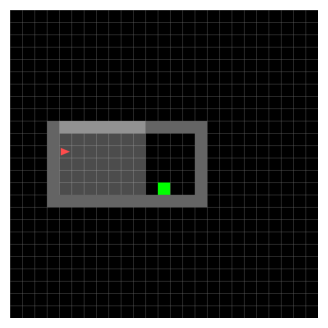

In [13]:
from display_functions import show_full_frame_rgb
env, obs = create_multiroom_env(1, 50, seed=333)
show_full_frame_rgb(env, obs)

Let's have a look on the stack in the 7 first step focusing on the deque mechanism:


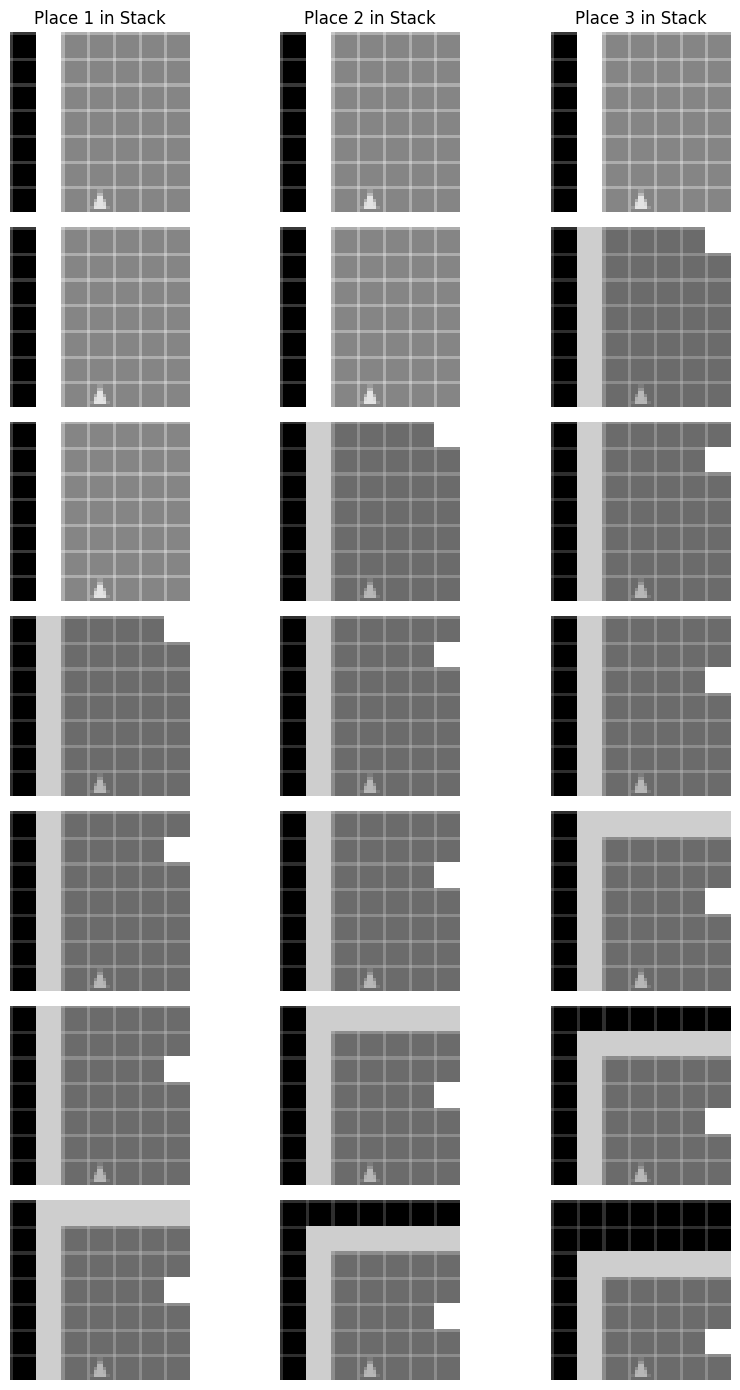

In [14]:
env, obs = create_multiroom_env(1, 50, seed=333)
frame_stack = FrameStackPreprocess(downsample_size=(56, 56))
frame_stack.reset(obs)
frame_stack.get_stack().shape

action = 2 # Always move forward

import matplotlib.pyplot as plt

def visualize_frame_stack(env, preprocessor, policy, N=7):
    """
    Runs N iterations, updates FrameStackPreprocess, and directly plots stack positions.

    Parameters:
        env: The MiniGrid environment (already initialized).
        preprocessor: Instance of FrameStackPreprocess.
        policy: Function that returns the action to take.
        N: Number of iterations.

    Returns:
        None (displays plots).
    """
    fig, axes = plt.subplots(N, preprocessor.num_frames, figsize=(9, 2 * N))  # N rows, num_frames columns

    for i in range(N):
        action = policy(env)  # Get action from policy
        obs, _, _, _, _ = env.step(action)  # Step in environment
        stacked_frames = preprocessor.update(obs)  # Update the stack

        for j in range(preprocessor.num_frames):  # Iterate over stacked frames
            axes[i, j].imshow(stacked_frames[j], cmap="gray")
            axes[i, j].axis("off")
            if i == 0:
                axes[i, j].set_title(f"Place {j+1} in Stack")

    plt.tight_layout()
    plt.show()



visualize_frame_stack(env, frame_stack, lambda env: 2)

As we can see, the stack work well, the transformation of the image still allows to distinct between the tiles of wall, open tile, doors and goal.
Now lets check the downsampling mechanism to reduce resolution for more efficent learning and better visualiztion:


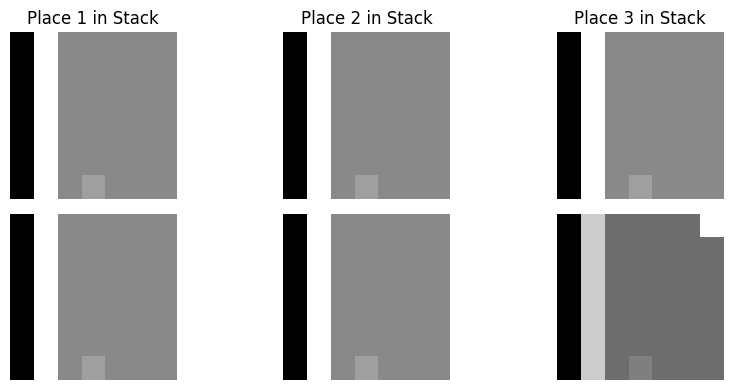

In [15]:
env, obs = create_multiroom_env(1, 50, seed=333)
frame_stack = FrameStackPreprocess(downsample_size=(7, 7))
frame_stack.reset(obs)
frame_stack.get_stack().shape
visualize_frame_stack(env, frame_stack, lambda env: 2, N=2)

## Implementing DQN


### QNet Class


In [16]:
class QNet(nn.Module):
    """
    Q-Network model for our RL task - the NN component for DQN, DDQN and Dueling DQN Agents.
    
    This network consists of:
    - Convolutional layers for feature extraction.
    - Fully connected layers for action selection.
    
    Args:
        input_size (Tuple[int, int, int]): Tuple representing (channels, height, width) of input.
        num_actions (int): Number of possible actions in the environment.

    Example:
        >>> model = DQN((4, 84, 84), num_actions=6)
        >>> x = torch.randn(1, 4, 84, 84)  # Batch of one sample
        >>> output = model(x)
        >>> print(output.shape)  # Expected: (1, 6)
    """

    def __init__(self, input_size: Tuple[int, int, int], num_actions: int, device=None) -> None:
        super().__init__()
        # define the device of self (the model)
        self.device = torch.device(device if device else ("cuda" if torch.cuda.is_available() else "cpu"))


        # Extract input dimensions
        c, h, w = input_size  # (number of frames, height, width)

        # Convolutional layers for feature extraction
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        ).to(self.device)

        # Compute the flattened size after convolutions
        conv_out_size = self._get_conv_size((c, h, w))

        # Fully connected layers for decision making
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )

        # Move model to DEVICE after initializing layers
        self.to(self.device)



    def _get_conv_size(self, shape: Tuple[int, int, int]) -> int:
        """
        Computes the flattened size of the feature maps after convolutional layers.

        Args:
            shape (Tuple[int, int, int]): Input shape (channels, height, width).

        Returns:
            int: Number of elements after flattening.
        """
        with torch.no_grad():
            dummy_tensor = self.conv(torch.zeros(1, *shape, device=self.device))  # Pass a dummy tensor
            return dummy_tensor.numel()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output Q-values for each action, shape (batch_size, num_actions).
        """
        x = x.to(self.device)  # Move input tensor to GPU
        x = self.conv(x)  # Apply convolutional layers
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # Apply fully connected layers
        return x



#### Test Qnet


In [17]:

print(DEVICE)
# Define input size and action space
input_size = (4, 10, 10)  # (channels, height, width) - example
num_actions = 5  # Example number of actions

# Initialize model
model = QNet(input_size, num_actions, DEVICE).to(DEVICE)

# Generate a test input (batch_size=1)
test_input = torch.ones(1, *input_size).to(DEVICE)  # All ones, should produce deterministic output

# Forward pass
output = model(test_input)

# Print output
print(f"Output shape: {output.shape}")  # Should be (1, num_actions)
print(f"Output values: {output.cpu().detach().numpy()}")  # Move to CPU before converting to NumPy


cuda
Output shape: torch.Size([1, 5])
Output values: [[-0.05863881  0.0223835   0.06157981 -0.05270583 -0.04277158]]


In [18]:
import torch.optim as optim
# Define loss function and optimizer
criterion = nn.SmoothL1Loss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Generate a single data point
x = torch.ones(1, *input_size).to(DEVICE) 
y_target = torch.zeros(1, num_actions).to(DEVICE)

# Training loop (few iterations)
for i in range(100):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y_target)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"Iteration {i}: Loss = {loss.item()}")

# Final check: Should decrease if network works
print("Final loss:", loss.item())


Iteration 0: Loss = 0.0012338915839791298
Iteration 10: Loss = 0.0004168886807747185
Iteration 20: Loss = 7.440242188749835e-05
Iteration 30: Loss = 1.5288682334357873e-05
Iteration 40: Loss = 1.2539524050225737e-06
Iteration 50: Loss = 1.8191836943515227e-06
Iteration 60: Loss = 9.60640477387642e-07
Iteration 70: Loss = 1.801078042262816e-07
Iteration 80: Loss = 1.2194425380585017e-07
Iteration 90: Loss = 5.993342000465418e-08
Final loss: 1.4069462928034682e-08


In [19]:
# Get initial parameters
initial_weights = {name: param.clone() for name, param in model.named_parameters()}

# Perform one training step
optimizer.zero_grad()
y_pred = model(x)
loss = criterion(y_pred, y_target)
loss.backward()
optimizer.step()

# Check if any parameters changed
for name, param in model.named_parameters():
    if torch.equal(param, initial_weights[name]):
        print(f"Warning: {name} did not update!")
    else:
        print(f"Parameter {name} updated correctly.")


Parameter conv.0.weight updated correctly.
Parameter conv.0.bias updated correctly.
Parameter conv.2.weight updated correctly.
Parameter conv.2.bias updated correctly.
Parameter fc.0.weight updated correctly.
Parameter fc.0.bias updated correctly.
Parameter fc.2.weight updated correctly.
Parameter fc.2.bias updated correctly.


### Replay Buffer Class


In [20]:
class ReplayBuffer:
    """
    A replay buffer for storing and sampling experiences for agents using Q networks.

    This buffer:
    - Stores experiences as (stacked_state, action, reward, stacked_next_state, done).
    - Maintains a deque for storing the last `buffer_size` experiences.
    - Samples complete frame stacks (not individual frames).
    - Provides batch sampling for training deep Q-networks.
    - Efficient memory management with a single device for buffer and batch operations.

    Args:
        buffer_size (int): Maximum number of experiences to store.
        batch_size (int): Number of samples to retrieve per batch.
        device (Optional[str]): The device on which the replay buffer and sampled batches are stored ("cpu" or "cuda").
    """

    def __init__(self, buffer_size: int, batch_size: int, device: Optional[str] = None) -> None:
        self.device: str = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        self.buffer_size: int = buffer_size
        self.batch_size: int = batch_size
        self.memory: Deque[Tuple[torch.Tensor, int, float, torch.Tensor, bool]] = deque(maxlen=buffer_size)  
        # Stores tuples of (stacked_state, action, reward, stacked_next_state, done)

    def add(self, stacked_state: np.ndarray | torch.Tensor, action: int, reward: float, 
            stacked_next_state: np.ndarray | torch.Tensor, done: bool) -> None:
        """
        Adds a new experience to the replay buffer, ensuring correct data types.

        Args:
            stacked_state (np.ndarray or torch.Tensor): Stacked state of shape (num_frames, H, W), dtype=np.uint8 (if np.ndarray) or torch.float32 (if already a tensor).
            action (int): Action taken.
            reward (float): Reward received.
            stacked_next_state (np.ndarray or torch.Tensor): Next stacked state of shape (num_frames, H, W), dtype=np.uint8 (if np.ndarray) or torch.float32 (if already a tensor).
            done (bool): Whether the episode ended.

        Returns:
            None

        Raises:
            TypeError: If inputs are not np.ndarray or torch.Tensor.
        """
        if isinstance(stacked_state, np.ndarray) and isinstance(stacked_next_state, np.ndarray):
            stacked_state = torch.tensor(stacked_state, dtype=torch.float32, device=self.device)
            stacked_next_state = torch.tensor(stacked_next_state, dtype=torch.float32, device=self.device)
        elif not (isinstance(stacked_state, torch.Tensor) and isinstance(stacked_next_state, torch.Tensor)):
            raise TypeError("stacked_state and stacked_next_state must be either both np.ndarray or both torch.Tensor")

        self.memory.append((stacked_state, action, reward, stacked_next_state, done))


    def sample(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Samples a batch from the replay buffer and keeps it on the same device.

        Returns:
            Tuple:
                - states_tensor (torch.Tensor): Shape (batch_size, num_frames, H, W), dtype=torch.float32.
                - actions_tensor (torch.Tensor): Shape (batch_size,), dtype=torch.int64.
                - rewards_tensor (torch.Tensor): Shape (batch_size,), dtype=torch.float32.
                - next_states_tensor (torch.Tensor): Shape (batch_size, num_frames, H, W), dtype=torch.float32.
                - dones_tensor (torch.Tensor): Shape (batch_size,), dtype=torch.float32.
        """
        if len(self.memory) < self.batch_size:
            raise ValueError("Not enough samples in the buffer to draw a batch.")

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to PyTorch tensors and ensure they stay on the same device
        states_tensor: torch.Tensor = torch.stack(states).to(self.device)
        next_states_tensor: torch.Tensor = torch.stack(next_states).to(self.device)
        actions_tensor: torch.Tensor = torch.tensor(actions, dtype=torch.int64, device=self.device)
        rewards_tensor: torch.Tensor = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        dones_tensor: torch.Tensor = torch.tensor(dones, dtype=torch.float32, device=self.device)

        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor

    def __len__(self) -> int:
        """
        Returns the current size of the replay buffer.

        Returns:
            int: The number of stored experiences.
        """
        return len(self.memory)


#### Test ReplayBuffer


In [21]:
import torch
import numpy as np
import cv2
import random
from collections import deque

# Create a dummy environment observation (RGB image)
img_size = (56, 56)
downsample_size = (7, 7)
num_frames = 3

# Create a FrameStackPreprocess instance
frame_stack = FrameStackPreprocess(num_frames=num_frames, img_size=img_size, downsample_size=downsample_size)

# Generate a random initial observation
obs = np.random.randint(0, 256, img_size + (3,), dtype=np.uint8)

# Reset the frame stack with the first observation
stacked_frames = frame_stack.reset(obs)

# Ensure the shape is (num_frames, downsample_size[0], downsample_size[1])
assert stacked_frames.shape == (num_frames, downsample_size[0], downsample_size[1]), "Frame stack shape mismatch"

# Generate new frames and update the stack
for _ in range(5):
    new_frame = np.random.randint(0, 256, img_size + (3,), dtype=np.uint8)
    stacked_frames = frame_stack.update(new_frame)

# Ensure the shape remains consistent
assert stacked_frames.shape == (num_frames, downsample_size[0], downsample_size[1]), "Updated frame stack shape mismatch"

# Create a ReplayBuffer instance
buffer_size = 10
batch_size = 4
device = "cpu"

replay_buffer = ReplayBuffer(buffer_size=buffer_size, batch_size=batch_size, device=device)

# Add experiences to the buffer
for _ in range(buffer_size):
    stacked_state = torch.tensor(stacked_frames, dtype=torch.float32)  # Convert to tensor
    action = random.randint(0, 3)  # Random action
    reward = random.uniform(-1, 1)  # Random reward
    stacked_next_state = torch.tensor(stacked_frames, dtype=torch.float32)  # Next state
    done = random.choice([True, False])

    replay_buffer.add(stacked_state, action, reward, stacked_next_state, done)

# Ensure the buffer is full
assert len(replay_buffer) == buffer_size, "Replay buffer did not fill correctly"

# Sample a batch
sampled_states, sampled_actions, sampled_rewards, sampled_next_states, sampled_dones = replay_buffer.sample()

# Ensure correct batch size
assert sampled_states.shape == (batch_size, num_frames, downsample_size[0], downsample_size[1]), "Sampled states shape mismatch"
assert sampled_next_states.shape == (batch_size, num_frames, downsample_size[0], downsample_size[1]), "Sampled next states shape mismatch"
assert sampled_actions.shape == (batch_size,), "Sampled actions shape mismatch"
assert sampled_rewards.shape == (batch_size,), "Sampled rewards shape mismatch"
assert sampled_dones.shape == (batch_size,), "Sampled dones shape mismatch"

# Ensure all tensors are on the correct device
assert sampled_states.device.type == device, "Sampled states not on correct device"
assert sampled_next_states.device.type == device, "Sampled next states not on correct device"
assert sampled_actions.device.type == device, "Sampled actions not on correct device"
assert sampled_rewards.device.type == device, "Sampled rewards not on correct device"
assert sampled_dones.device.type == device, "Sampled dones not on correct device"

print("All tests passed successfully.")


All tests passed successfully.


### Agent Class


In [155]:
class BaseAgent(ABC):
    """
    Abstract base class for all Deep Q-Network (DQN)-based agents.

    This class provides:
    - Initialization of neural networks (policy & target).
    - Common hyperparameters for training (gamma, learning rate, epsilon, etc.).
    - A method to update the target network at fixed intervals.
    - A replay buffer for experience storage.

    Subclasses must implement:
    - `_build_model()` → Defines the neural network.
    - `select_action()` → Chooses an action using an epsilon-greedy strategy.
    - `train_step()` → Implements the training logic.
    """

    def __init__(
        self,
        gamma: float,
        lr: float,
        target_update_freq: int,
        device: torch.device = None,
        buffer_device: str = "cpu",
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        epsilon_decay: float = 0.995,
        frames_in_stack: int = 3,
        downsample_size: Tuple[int, int] = (7, 7),
        batch_size: int = 32,
        buffer_size: int = 10_000,
        actions_space: list[int] = ACTIONS_SPACES,
        action_space_mapped: dict[int, int] = ACTIONS_SPACES_MAPPED,
        use_amp = None
    ) -> None:
        """
        Initializes the BaseAgent with RL hyperparameters relevant to most algorithms.

        Args:
            gamma (float): Discount factor for future rewards.
            lr (float): Learning rate.
            target_update_freq (int): Number of steps between target network updates.
            device (torch.device, optional): Computation device ('cuda' or 'cpu'). Default is auto-detected.
            buffer_device (str): Device for the replay buffer storage ('cpu' or 'cuda'). Default is 'cpu'.
            max_epsilon (float): Maximum exploration probability (initial epsilon).
            min_epsilon (float): Minimum exploration probability.
            epsilon_decay (float): Decay rate for epsilon after each step.
            frames_in_stack (int): Number of frames to stack as state representation.
            downsample_size (Tuple[int, int]): Target resolution after downsampling (Height, Width).
            batch_size (int): Number of samples per training batch.
            buffer_size (int): Maximum number of experiences stored in the replay buffer.
            actions_space (list[int]): List of possible actions.
                - 0: Turn left
                - 1: Turn right
                - 2: Move forward
                - 5: Toggle (open/close doors)
            action_space_mapped (dict[int, int]): Mapped action indices.

        Returns:
            None
        """

        self.device = torch.device(device if device else ("cuda" if torch.cuda.is_available() else "cpu"))

        self.gamma = gamma
        self.lr = lr
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.actions_space = actions_space
        self.use_amp = use_amp if use_amp is not None else torch.cuda.is_available()  # Auto-detect AMP

        # Frame Stack Preprocessor initialization
        self.frame_stack = FrameStackPreprocess(frames_in_stack, downsample_size)

        # Replay buffer to store past experiences
        self.memory = ReplayBuffer(buffer_size, batch_size, device=self.device)

        # Initialize policy and target networks
        self.policy_net = self._build_model().to(self.device)
        self.target_net = self._build_model().to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())  # Synchronize initial weights
        self.target_net.to(self.device)
        self.target_net.eval()  # Target network does not require gradients
        self.target_updates_count = 0

        # Optimizer for training the policy network
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.scaler = GradScaler() if self.use_amp else None

        # Values for Monitoring and Debugging #
        self.train_step_count = 0  # Total training steps taken
        self.episode_reward = 0.0  # Total reward accumulated in the current episode
        self.action_counts = {a: 0 for a in self.actions_space}  # Count of selected actions
        self.episode_length = []  # Number of steps in each episode
        self.epsilon_history = []  # Records of epsilon values over time
        self.loss_history = []  # Tracks loss values during training
        self.q_values_history = []  # Tracks Q-values over time
        self.grad_norms = []  # Stores gradient norms during training

    @abstractmethod
    def _build_model(self) -> nn.Module:
        """
        Defines the neural network architecture.

        This method must be implemented in subclasses to create a specific DQN model.

        Returns:
            nn.Module: The initialized neural network.
        """
        pass

    @abstractmethod
    def select_action(self, state: np.ndarray) -> int:
        """
        Selects an action based on the given state.

        Subclasses must implement this method.

        Args:
            state (np.ndarray): The current state representation of shape (num_frames, H, W).

        Returns:
            int: The selected action.
        """
        pass

    @abstractmethod
    def _choose_action_and_compute_loss(self) -> None:
        """
        Performs a single training step.

        This method must be implemented in subclasses and should include:
        - Sampling experiences from the replay buffer.
        - Computing the Q-learning target values.
        - Optimizing the policy network.
        - Updating the target network when required.

        Returns:
            None
        """
        pass

    def train_step(self):
        """Runs train_step() inside AMP and handles optimization, updates, and epsilon decay."""
        if len(self.memory) < self.memory.batch_size:
            # return None, None, None  # Not enough samples in the buffer
            print("🚨 Not enough samples in memory - Returning (0,0,0)")
            return 0,0,0

        if self.use_amp:
            with autocast(device_type="cuda"):  # Use mixed precision if AMP is enabled
                loss, q_values, _ = self._choose_action_and_compute_loss()
        else:
            loss, q_values, _ = self._choose_action_and_compute_loss()

        # print("i computed loss, q_values, grad_norm")
        
        if loss is None:
            # return None, None, None  # Skip update if loss isn't computed
            print("🚨 Loss is None - Returning (0,0,0)")
            return 0,0,0

        # Perform optimization
        self.optimizer.zero_grad()
        if self.use_amp:
            #     self.scaler.scale(loss).backward()
            #     self.scaler.step(self.optimizer)
            #     self.scaler.update()
            self.scaler.scale(loss).backward()

            # Unscale gradients before clipping
            self.scaler.unscale_(self.optimizer)

            # Compute grad norm after unscaling
            grad_norm = torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=10).item()

            # Step optimizer with scaled loss
            self.scaler.step(self.optimizer)
            self.scaler.update()

        else:
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=10).item()
            self.optimizer.step()

        # Update target network if needed
        self.train_step_count += 1
        if self.train_step_count % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            self.target_updates_count += 1

        return loss.item(), q_values, grad_norm


    def update_target_network(self) -> None:
        """
        Copies weights from the policy network to the target network at fixed intervals.

        The update happens every `target_update_freq` training steps.

        Returns:
            None
        """
        if self.train_step_count % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            self.target_updates_count += 1
            # print(f"Target network updated at step {self.train_step_count}")


### DQN Agent


In [158]:

class DQNAgent(BaseAgent):
    def __init__(self, *args, **kwargs):
        """
        Initializes DQNAgent while inheriting all attributes from BaseAgent.
        """
        # Call the parent constructor to initialize all attributes
        super().__init__(*args, **kwargs)
        
        # Define policy and target networks (BaseAgent already initializes other attributes)
        self.policy_net = self._build_model().to(self.device)
        self.target_net = self._build_model().to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())  # Sync weights
        self.target_net.eval()  # Target net does not require gradients

        # Define optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)  
        
        # initialize epsilon
        self.epsilon = self.max_epsilon

    def _build_model(self) -> nn.Module:
        """
        Defines the neural network model for the DQN agent.
        """
        return QNet((self.frame_stack.num_frames,*self.frame_stack.downsample_size),
                    len(self.actions_space)).to(self.device)

    def select_action(self, state: np.ndarray) -> int:
        """
        Selects an action using an epsilon-greedy strategy.
        """
        if random.random() < self.epsilon: # Explore
            return random.choice(self.actions_space)  
        else: # Exploit
            state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy_net(state_tensor)
            return self.actions_space[q_values.argmax(dim=1).item()]

    def _choose_action_and_compute_loss(self):
            """Only computes loss, does not handle optimization (AMP is in BaseAgent)"""
            
            states, actions, rewards, next_states, dones = self.memory.sample()

            # Convert actions to tensor indices
            action_mapping = {0: 0, 1: 1, 2: 2, 5: 3}
            actions_mapped = actions.clone()
            for key, value in action_mapping.items():
                actions_mapped[actions == key] = value

            # Compute Q-values for current states
            states = states.to(self.device)
            q_values = self.policy_net(states).gather(1, actions_mapped.unsqueeze(1)).squeeze(1)        

            # Compute target Q-values
            with torch.no_grad():
                next_q_values = self.target_net(next_states).max(1)[0]
                target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

            # Compute loss (No need for backward or optimization here!)
            loss = F.smooth_l1_loss(q_values, target_q_values)

            # compute and Clip the gardient 
            # grad_norm = torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=10).item()


            return loss, q_values.mean().item(), None #grad_norm  # Grad norm will be handled in BaseAgent
    

#### Test DQN Agent


Using AMP: True


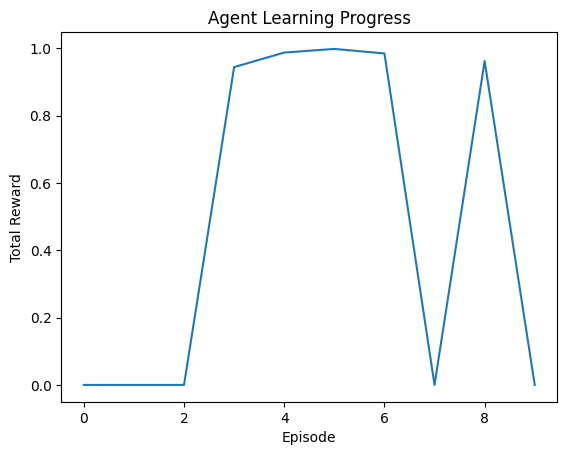

In [159]:


from sympy import use


env, obs = create_multiroom_env(num_rooms=1, max_room_size=10, seed=5, max_steps=1000)

gamma = 0.99  
learning_rate = 1e-3  
max_epsilon=1
epsilon_decay= 0.99
min_epsilon=0.1
target_update_freq = 10 

# Initialize DQNAgent
agent = DQNAgent(
    gamma=gamma,
    lr=learning_rate,
    max_epsilon=max_epsilon,
    epsilon_decay=epsilon_decay,
    min_epsilon=min_epsilon,
    target_update_freq=target_update_freq,
    device=DEVICE,
)
print(f"Using AMP: {agent.use_amp}")
# Environment setup
num_episodes = 10
max_steps_per_episode = 100  # Limit steps per episode
batch_size = 32  # Training starts after collecting 32 samples
episode_rewards = []


for episode in range(num_episodes):
    state, _ = env.reset()

    # print(agent.device)

    stacked_frame = agent.frame_stack.reset(state)
    # print(agent.device)   
    episode_reward = 0

    for step in range(max_steps_per_episode):
        # Select action using ε-greedy (already implemented inside select_action)
        # print(episode, step)
        action = agent.select_action(stacked_frame)
        # print(f"Selected action: {action}, Type: {type(action)}, Device: {agent.device if isinstance(action, torch.Tensor) else 'N/A'}")

        # Step in environment
        next_state, reward, done, truncated, _ = env.step(action)
        next_state_stacked = agent.frame_stack.update(next_state)  # Preprocess next state

        agent.memory.add(stacked_frame, action, reward, next_state_stacked, done)
         # Start training only after 32 samples in replay buffer
        if len(agent.memory) >= batch_size:
            batch = agent.memory.sample()
            agent.train_step()

        # Update state and track reward
        state = next_state_stacked
        episode_reward += reward

        if done or truncated:
            break

            # Store episode reward
    episode_rewards.append(episode_reward)
    # print(f"Episode {episode+1}: Reward = {episode_reward}")

# Plot rewards over time
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Agent Learning Progress")
plt.show()



### Trainer


In [160]:
class Trainer:
    def __init__(self, env, agent, num_episodes=500, max_steps=10000, batch_size=32, log_interval=10,save_video_interval=500):
        """
        Trainer class to handle RL training for different agents.

        Args:
            env: Gym environment
            agent: RL agent (e.g., DQNAgent, BaseAgent)
            num_episodes: Total episodes to train
            max_steps: Max steps per episode
            batch_size: Batch size for training
            log_interval: Interval for printing logs
        """
        self.env = env
        self.agent = agent
        self.num_episodes = num_episodes
        self.max_steps = max_steps
        self.batch_size = batch_size
        self.log_interval = log_interval
        self.save_video_interval = save_video_interval


        self.video_dir = f"videos/{self.agent.__class__.__name__}_{time.strftime('%Y%m%d-%H%M%S')}"
        os.makedirs(self.video_dir, exist_ok=True)

    
        self.rewards_log = []  # Store rewards per episode
        self.loss_log = []  # Store loss per episode
        self.epsilon_history = []  # Store epsilon values
        self.episode_lengths = [] 
        self.q_values_history = []  # Store Q-values over time
        self.grad_norms = []  # Store gradient norms
        self.action_counts = {a: 0 for a in self.agent.actions_space}  # Action selection counts
        self.success_rate = []
    
    @contextmanager
    def video_recorder(self, episode):
        """Context manager for recording videos."""
        video_path = os.path.join(self.video_dir, f"episode_{episode + 1}.mp4")

        if (episode + 1) % self.save_video_interval == 0:
            video = imageio.get_writer(video_path, fps=10)
            try:
                yield video  # Open video recording
            finally:
                video.close()  # Ensure video is closed
        else:
            yield None  # No video recording for this episode


    def train(self, existing_agent=None, another_env=None):
        """Runs the training loop."""
        if existing_agent:
            self.agent = existing_agent
        if another_env:
            self.env = another_env

        progress_bar = tqdm(range(self.num_episodes), desc="Training Progress", unit="episode")

        for episode in range(self.num_episodes):
            
            state, _ = self.env.reset()
            stacked_state = self.agent.frame_stack.reset(state)
            episode_losses, episode_q_values, episode_grad_norms = [], [], []
            episode_reward = 0
            episode_length = 0

            with self.video_recorder(episode) as video:
                if video: video.append_data(self.env.render())
                for step in range(self.max_steps):
                    action = self.agent.select_action(stacked_state)
                    self.action_counts[action] += 1  # Track action selection
                    next_state, reward, done, truncated, _ = self.env.step(action)
                    if video: video.append_data(self.env.render())                     
                    stacked_next_state = self.agent.frame_stack.update(next_state)
                    self.agent.memory.add(
                        torch.tensor(stacked_state, dtype=torch.float32, device=self.agent.device),
                        torch.tensor(action, dtype=torch.int64, device=self.agent.device),
                        torch.tensor(reward, dtype=torch.float32, device=self.agent.device),
                        torch.tensor(stacked_next_state, dtype=torch.float32, device=self.agent.device),
                        torch.tensor(done, dtype=torch.float32, device=self.agent.device)
                    )
                    
                    # print("self.agent.memory ", len(self.agent.memory))
                    # print("self.batch_size ", self.batch_size)
                    # print("------------------------")
                    if len(self.agent.memory) >= self.batch_size:
                        loss, q_value, grad_norm = self.agent.train_step()
                        episode_losses.append(loss)
                        episode_q_values.append(q_value)
                        episode_grad_norms.append(grad_norm)
                    
                    stacked_state = stacked_next_state
                    episode_reward += reward
                    episode_length += 1
                    self.agent.epsilon = max(self.agent.epsilon * self.agent.epsilon_decay, self.agent.min_epsilon)

                    if done or truncated:
                        if video is not None: video.append_data(self.env.render())
                        self.success_rate.append(1 if done else 0)
                        break

            progress_bar.update(1)

            # Log statistics
            self.rewards_log.append(episode_reward)
            self.episode_lengths.append(episode_length)
            self.epsilon_history.append(self.agent.epsilon)

            self.loss_log.append(np.mean([l for l in episode_losses if l is not None]) if episode_losses else 0)
            self.q_values_history.append(np.mean([q for q in episode_q_values if q is not None]) if episode_q_values else 0)
            self.grad_norms.append(np.mean([g for g in episode_grad_norms if g is not None]) if episode_grad_norms else 0)

            # self.loss_log.append(np.mean(episode_losses) if episode_losses else 0)
            # self.q_values_history.append(np.mean(episode_q_values) if episode_q_values else 0)
            # self.grad_norms.append(np.mean(episode_grad_norms) if episode_grad_norms else 0)

            if (episode + 1) % self.log_interval == 0:
                progress_bar.set_description(f"Episode {episode+1}/{self.num_episodes} | Reward: {episode_reward:.2f} | Loss: {np.mean(episode_losses) if episode_losses else 'N/A'} | Updates counter: {agent.target_updates_count} " )

        return self.agent
        

def evaluate(self, num_episodes=100, freq_saving_video=20):
    """Evaluates the trained agent without exploration, with optional video saving."""
    rewards = []

    for episode in tqdm(range(num_episodes), desc="Evaluating", unit="episode"):
        state, _ = self.env.reset()
        stacked_state = self.agent.frame_stack.reset(state)
        episode_reward = 0

        with self.video_recorder(episode, freq_saving_video) as video:
            if video:
                video.append_data(self.env.render())

            for step in range(self.max_steps):
                action = self.agent.select_action(stacked_state, greedy=True)
                next_state, reward, done, truncated, _ = self.env.step(action)
                stacked_state = self.agent.frame_stack.update(next_state)
                episode_reward += reward
                if video: video.append_data(self.env.render())
                if done or truncated:
                    break
        rewards.append(episode_reward)
        self.episode_lengths.append(step)

    avg_reward = np.mean(rewards)
    print(f"✅ Average Evaluation Reward: {avg_reward:.2f}")

    
    def save_model(self, path):
        """Saves the agent model."""
        torch.save(self.agent.q_network.state_dict(), path)
        print(f"Model saved at {path}")

    def load_model(self, path):
        """Loads a saved model."""
        self.agent.q_network.load_state_dict(torch.load(path))
        self.agent.q_network.eval()
        print(f"Model loaded from {path}")
    



In [161]:

def init_env_DQNagent_train(
                         num_rooms=1,
                         max_room_size=6,
                         env_seed=None,
                         frames_in_stack=3,
                         downsample_size=(7, 7),
                         gamma=0.99,
                         learning_rate=0.00025,
                         max_epsilon=1.0,
                         epsilon_decay=0.9995,
                         min_epsilon=0.01,
                         target_update_freq=10000,
                         action_space=ACTIONS_SPACES,
                         num_episodes=10,
                         max_steps=10000,
                         buffer_size=10,
                         batch_size=32,
                         log_interval=10,
                         save_video_interval=500):
    """Initializes environment, agent, and trainer for training."""
    
    if env_seed is None:
        env_seed = np.random.randint(0, 100000)

    env, obs = create_multiroom_env(num_rooms, max_room_size, seed=env_seed)


    agent = DQNAgent(
        frames_in_stack=frames_in_stack,
        downsample_size=downsample_size,
        gamma=gamma,
        lr=learning_rate,
        max_epsilon=max_epsilon,
        epsilon_decay=epsilon_decay,
        min_epsilon=min_epsilon,
        target_update_freq=target_update_freq,
        actions_space=action_space,
        batch_size=batch_size,
        buffer_size=buffer_size
    )
    trainer = Trainer(
        env=env,
        agent=agent,
        num_episodes=num_episodes,
        max_steps=max_steps,
        batch_size=batch_size,
        log_interval=log_interval,
        save_video_interval=save_video_interval
    )

    # Train the agent
    trainer.train()

    # Plot training progress
    plot_training_process(trainer)
    
    return env, agent, trainer



Training Progress:   0%|          | 0/100 [00:00<?, ?episode/s]

Episode 100/100 | Reward: 0.78 | Loss: 0.000602247379720211 | Updates counter: 60 : 100%|██████████| 100/100 [00:23<00:00,  4.18episode/s]


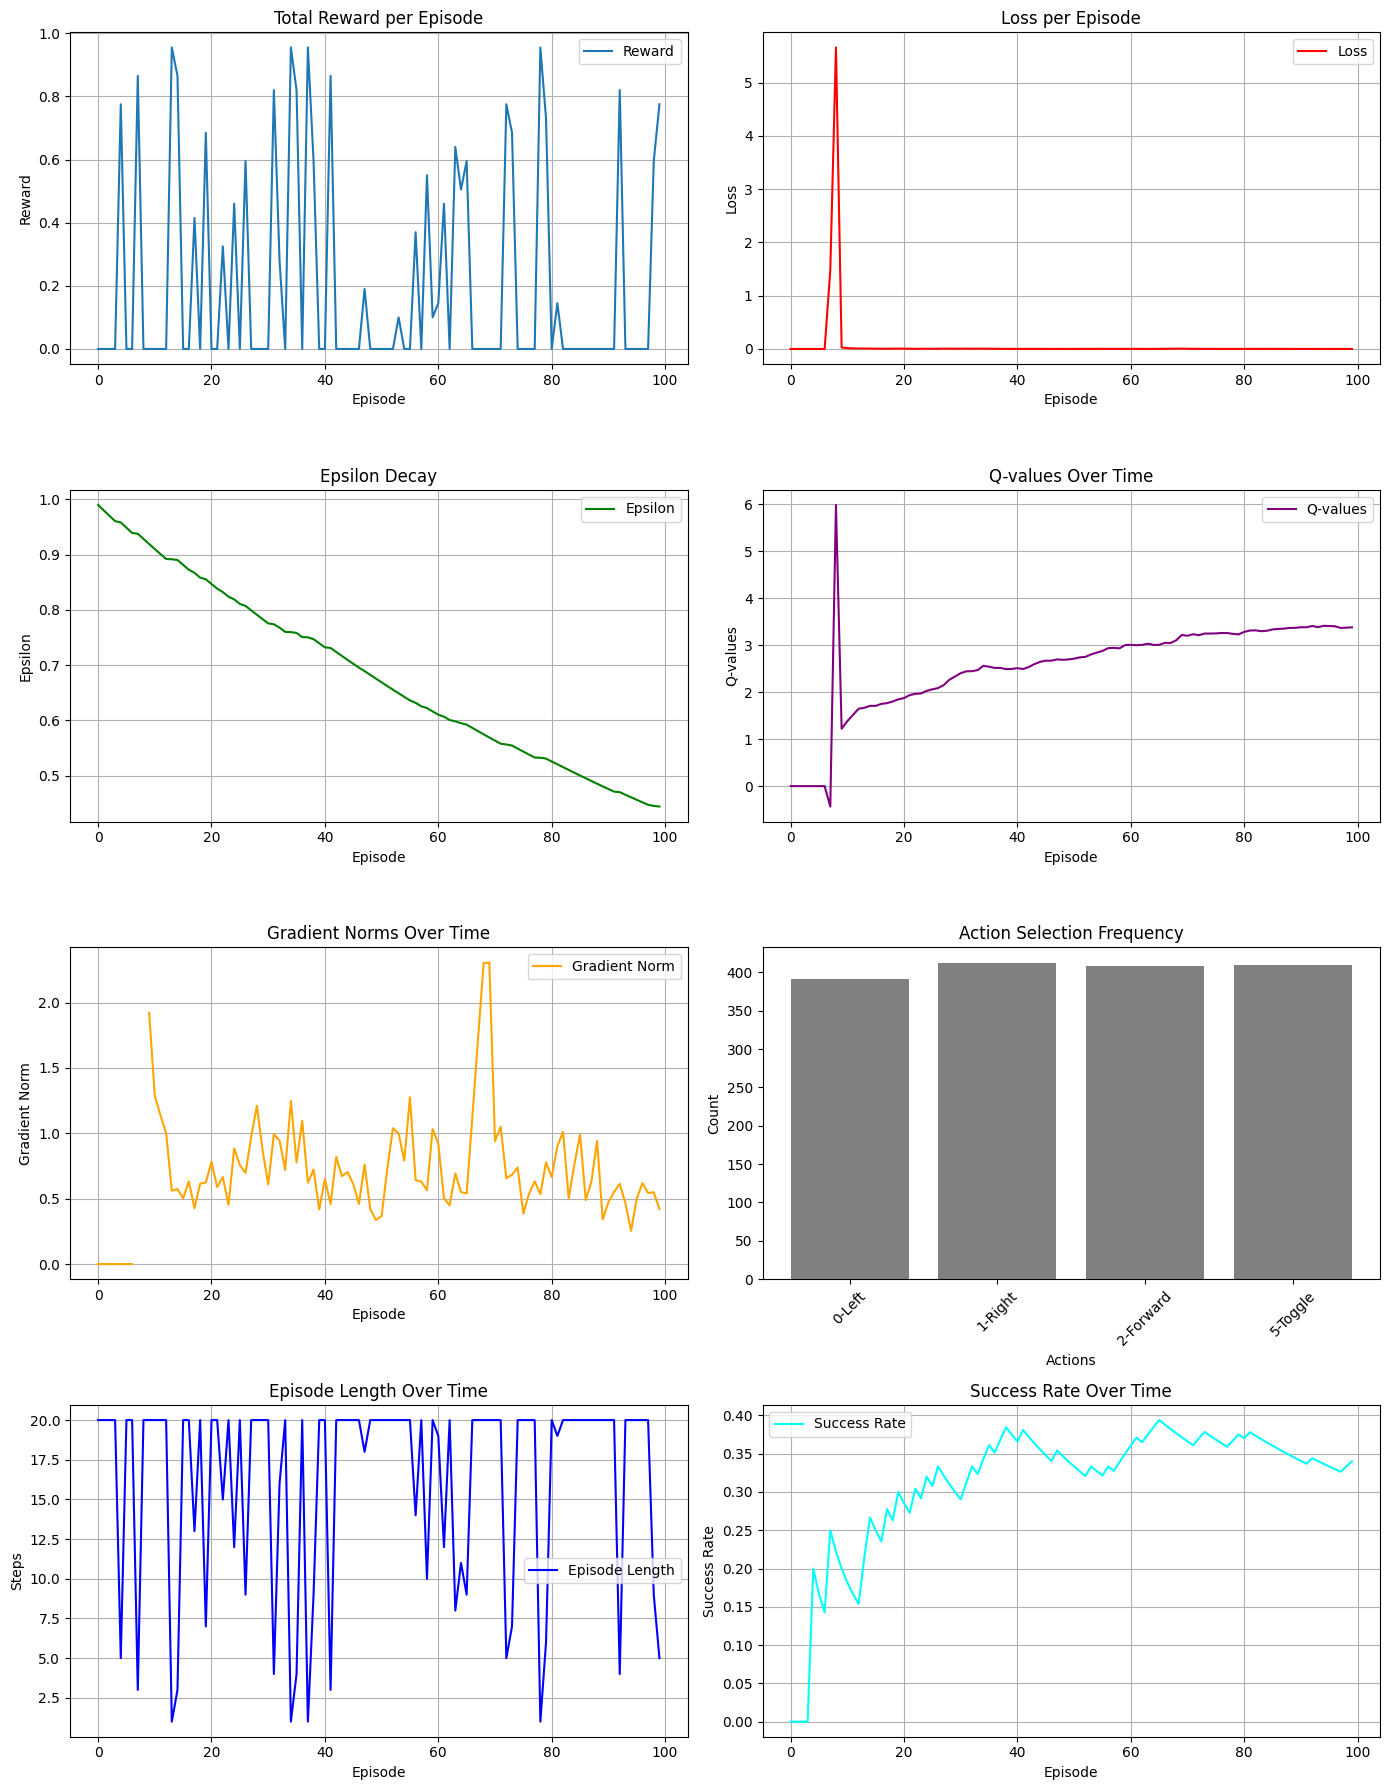

In [162]:
import display_functions
importlib.reload(display_functions)
from display_functions import plot_training_process

env, agent, trainer = init_env_DQNagent_train(
                         num_rooms=1,
                         max_room_size=4,
                         max_steps=10000,
                         env_seed=None,
                         frames_in_stack=3,
                         downsample_size=(7, 7),
                         gamma=0.99,
                         learning_rate=0.0005,
                         max_epsilon=1.0,
                         epsilon_decay=0.9995,
                         min_epsilon=0.01,
                         target_update_freq=20,
                         action_space=ACTIONS_SPACES,
                         num_episodes=100,
                         batch_size=128,
                         buffer_size=1000,
                         log_interval=1,
                         save_video_interval=5)
                        




In [30]:
render_agent_video(env,agent)


Saving video to: videos/agent_video.mp4
!!!!!!
here
Error during video generation: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 56, 56, 3] to have 3 channels, but got 56 channels instead


In [31]:
env, agent, trainer = init_env_DQNagent_train(
                         num_rooms=2,
                         max_room_size=5,
                         env_seed=None,
                         frames_in_stack=3,  # Enough to capture movement context
                         downsample_size=(7, 7),  # Small size for efficiency
                         gamma=0.99,  # Long-term planning
                         learning_rate=0.00025,  # More stable training
                         max_epsilon=1.0,  # Full exploration at start
                         epsilon_decay=0.99975,  # Slower decay for better exploration
                         min_epsilon=0.05,  # Higher min to prevent getting stuck
                         target_update_freq=500,  # More frequent target updates for stability
                         action_space=ACTIONS_SPACES,
                         num_episodes=500,  # More training for better learning
                         max_steps=500,  # Limits each episode's length
                         batch_size=64,  # Lower batch size for faster updates
                         buffer_size=50000,  # Large enough to store diverse experiences
                         log_interval=10,  # Log every 10 episodes
                         save_video_interval=1000  # Less frequent video saving
)


Episode 30/500 | Reward: 0.00 | Loss: 0.015068822860484943 | Updats counter: 19 :   6%|▌         | 31/500 [00:18<04:51,  1.61episode/s]

KeyboardInterrupt: 

In [ ]:
import torch

# Check CUDA
print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0))
print("PyTorch Device:", torch.device("cuda"))

# Run a small test tensor on GPU
x = torch.randn(10000, 10000, device="cuda")  # Large tensor to check GPU usage
y = x @ x  # Matrix multiplication should run on GPU
print("Tensor on GPU:", y.device)


if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")


torch.backends.cudnn.benchmark = True

## Implementing Policy Based
